--- 
description: Here we show how to solve minimum maximal matching problem using JijZept and JijModeling.
---

# Minimum Maximal Matching

We show how to solve the minimum maximal matching problem using JijZept and JijModeling. 
This problem is also mentioned in 4.5. Minimal Maximal Matching on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Minimum Maximal Matching? 

The minimum maximal matching is a matching problem in graphs, where the matching is a set of edges in a graph that do not share any vertices with each other.

We assume that we have an undirected graph $G = (V,E)$ and that $C \subseteq E$ is a “coloring” of vertices.
The constraints on $C$ are given as follows.
For each edge in $C$, we color the two vertices it connects to be the same.
We then promise that no two edges in $C$ share a same vertex and that $(u,v) \notin E$ if $u, v \notin D$,
where $D$ is the set of vertices that are connected to any edge in $C$.
This is maximal in the sense that we cannot add any more edge to $C$ without violating the first constraint
while we must include all edges between uncolored vertices as long as they do not violate the first constraint;
*i.e.* the empty set is not allowed.
Such a coloring is the minimum when and only when the number of edges in $C$ is the smallest possible.

### Example

For example, consider that we have a graph $G = (V, E)$, where $V = {1,2,3,4,5}$ and where $E = {(1,2),(1,3),(2,3),(3,4),(4,5)}$.
To find a maximal matching, we first have the empty set as a matching.
Then, we add edges to the matching until we cannot add any more edge without violating the constraints.
In such a small problem, one may be able to find the minimum maximal matching with some trials and errors.
Indeed the minimum maximal matching for this graph is ${(1,2), (3,4)}$.

## Mathematical model

A binary variable $x_e$ denotes whether or not the edge $e$ is colored;
the edge is colored if $x_e$ is 1, and vice versa.
We also introduce a binary variable $y_v$ that denotes whether or not the vertex $v$ is included in the matching ($D$ in the above statements);
the vertex is connected to a edge in $C$ if $y_v = 1$, and vice versa.

**Constraint 1: relationship between $x$ and $y$**

By definition, the condition below obviously holds.
$$
\quad y_v = \sum_{e \in E_v} x_e \quad \forall v,
$$
where $E_v$ is the set of edges that are connected to the vertex $v$.

**Constraint 2: every unselected edge is connected to at least one vertex connected to a selected edge**

To formulate this we use a basic observation: $1-y_{v}$ is 0 if $u$ is connected to a selected edge, and vice versa.
Then, by counting $(1-y_{u})(1-y_{v})$ for all $(u,v) \in E$, we can check the violation of the constraint;
*i.e.* if $(1-y_{u})(1-y_{v}) > 0$ for any $(u,v) \in E$, the edge $(u,v)$ can be selected without violating the constraints.
$$
\quad \sum_{(u,v)\in E} (1-y_u)(1-y_v) = 0.
$$

**Objective function: minimize the size of the matching**

The size here means the number of edges selected.
$$
\quad \min \sum_{e \in E} x_e.
$$


## Modeling by JijModeling
Next, we show how to implement above equations using JijModeling.
We first define the variables in the mathematical model described above.

In [3]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
num_E = E.shape[0]
x = jm.BinaryVar('x', shape=(num_E,))
y = jm.BinaryVar('y', shape=(V,))
v = jm.Element('v', V)
e = jm.Element('e', num_E)

# Constraint
The constraints and the objective function are written as:


In [4]:
problem = jm.Problem('Minimum Maximal Matching')
problem += jm.Constraint('y_x_relation', y[v] - jm.sum((e, (E[e][0]==v)|(E[e][1]==v)), x[e])  == 0 ,forall=v)
problem += jm.Constraint('unselected_edge', jm.sum(e, (1-y[E[e][0]])*(1-y[E[e][1]]))==0)

problem += x[:].sum()


On Jupyter Notebook, one can check the problem statement in a human-readable way by hitting


In [5]:
problem

## Prepare an instance
Here we use the same instance with an example described above.


In [6]:
import networkx as nx

# set empty graph
inst_G = nx.Graph()
V = [0, 1, 2, 3, 4]
# add edges
inst_E = [[0, 1], [0, 2], [1, 2], [2, 3], [3, 4]] 
inst_G.add_edges_from(inst_E)
# get the number of nodes
inst_V = list(inst_G.nodes)
num_V = len(inst_V)
instance_data = {'V': num_V, 'E': inst_E}


This graph is shown below.

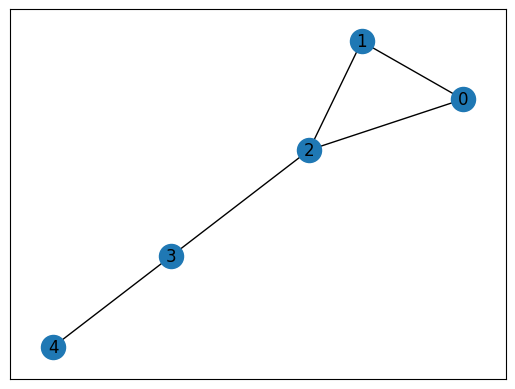

In [7]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(inst_G)
nx.draw_networkx(inst_G, pos=pos, with_labels=True)
plt.show()

## Solve by JijZept's SA

We solve this problem using JijSASampler.
We also turn on a parameter search function by setting `search=True`.

In [8]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="../../../config.toml")
# solve problem
multipliers = {"y_x_relation": 0.5, "unselected_edge": 0.5}
response = sampler.sample_model(problem, instance_data, multipliers=multipliers, search=True)

## Visualize the solution

The optimized solution can be seen as below.


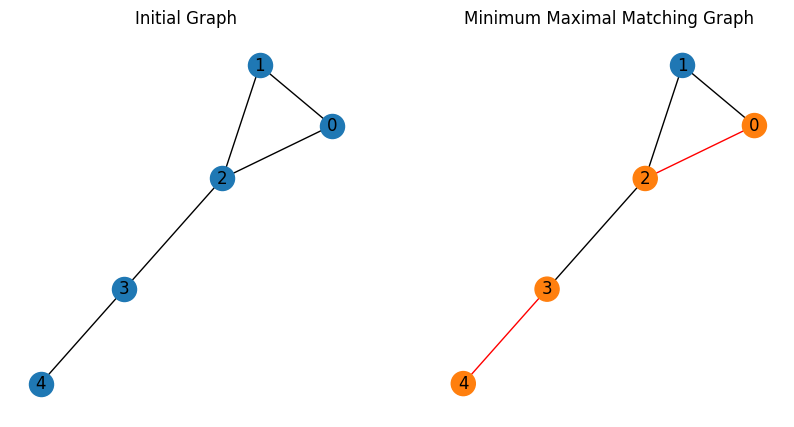

In [9]:
import numpy as np

# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
# get the values of feasible objectives
feasible_objectives = [sample.eval.objective for sample in feasible_samples]
if len(feasible_objectives) == 0:
    print("No feasible sample found ...")
else:
    # get the index of lowest value of feasible objectives
    lowest_index = np.argmin(feasible_objectives)
    # get the lowest solution
    lowest_solution = feasible_samples[lowest_index].var_values
    # get the indices of x == 1
    x_indices = [key[0] for key in lowest_solution["x"].values.keys()]
    # get the indices of y == 1
    y_indices = [key[0] for key in lowest_solution["y"].values.keys()]
    # set color list for visualization
    cmap = plt.get_cmap("tab10")
    # set vertex color
    vertex_colors = [cmap(1) if i in y_indices else cmap(0) for i in inst_V]
    # set edge color list
    edge_colors = ["red" if j in x_indices else "black" for j, _ in enumerate(instance_data["E"])]
    # dwaw the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # plot the initial graph
    nx.draw_networkx(inst_G, pos, with_labels=True, ax=ax1)
    ax1.set_title('Initial Graph')
    plt.axis('off')
    ax1.set_frame_on(False) # Remove the frame from the first subplot
    # plot the minimum maximal matching graph
    nx.draw_networkx(inst_G, pos=pos, node_color=vertex_colors, edge_color=edge_colors, with_labels=True)
    plt.axis('off')
    ax2.set_title('Minimum Maximal Matching Graph')
    # Show the plot
    plt.show()

As expected, we have obtained the minimum maximal matching graph.